## Imports and Load Data

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from pandas import Timestamp
import sys
from pathlib import Path
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.width', None)
sys.path.append(str(Path("/Users/nk/Acedemic/Masters/KULEUVEN/Thesis/project_second/survival_project/src").resolve()))

# Import the function after adding the correct path
from functions import drop_columns_with_nan_greater_than_threshold, get_columns_with_nan_percentage, get_features_info

In [2]:

raw_data = pd.read_csv("/Users/nk/Acedemic/Masters/KULEUVEN/Thesis/project_second/survival_project/raw_data 1.csv")
raw_data.shape

/var/folders/2_/bhldy0qj4k5dfrybcw8kkm6m0000gn/T/ipykernel_32327/92875212.py:1: DtypeWarning: Columns (3,8) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("/Users/nk/Acedemic/Masters/KULEUVEN/Thesis/project_second/survival_project/raw_data 1.csv")


(5238, 8898)

In [3]:
clean_data = raw_data.copy()
clean_data.shape

(5238, 8898)

## Feature Engineering

In [4]:
clean_data["listing_date"] = pd.to_datetime(clean_data["First.listing.date"])
clean_data["bankrupcty_date"] = pd.to_datetime(clean_data["risk.time"])
clean_data["status"] = clean_data["risk.time"].apply(lambda x: 0 if pd.isna(x) else 1)
clean_data["bankrupcty_date"] = clean_data["bankrupcty_date"].apply(lambda x: Timestamp("2020-12-31") if pd.isna(x) else x)
clean_data["survival_time"] = (clean_data["bankrupcty_date"] - clean_data["listing_date"]).dt.days/365.25
clean_data["censoring_time"] = (Timestamp("2020-12-31") - clean_data["listing_date"]).dt.days/365.25

### Creating a df from column names to manage the features and lags

In [5]:
column_names_df = get_features_info(clean_data)

In [6]:
column_names_df.columns

Index(['Column Names', 'Feature', 'Suffix', 'Before Year', 'Year',
       'After Year'],
      dtype='object')

### Function of Algorithm With percentages to delete the rows and columns with high percentage of NaNs

In [7]:
def run_algorithm(clean_data, column_names_df , s,c,l):
    s = s
    c1 = c
    l = l
    print("s", s)
    print("Initial Shape of data:",clean_data.shape)
    C_init = clean_data[clean_data["status"]==1].shape[0] # Number of uncensored firms at the beginning
    print("No of uncensored firms C_init:", C_init)
    print("==============")
    # Step 1: Filter firms with T ≥ s
    df = clean_data[clean_data["survival_time"] >= s].copy()
    N, p = df.shape # Number of firms and number of features at the beginning
    print("Shape of data after step1:",df.shape)
    C_after_step_st = df[df["status"]==1].shape[0] # Number of uncensored firms at the beginning
    print("No of uncensored firms after step 1:", C_after_step_st)
    print("==============")
    print("Iterations :")
    # Group columns by covariate
    column_names=column_names_df[6:-6].reset_index(drop=True)

    # Initialize best result
    best_dataset = None
    max_uncensored = C_after_step_st

    # Step 4–11: Loop over thresholds
    for a in range(c1, 40, -l):
        b = a-10
        print("a, b :", a,b)

        # Step 2: Missing values per firm
        df["nan_percentage"] = df.iloc[:,6:-6].isna().sum(axis=1) / df.iloc[:,6:-6].shape[1] * 100
        df =df[df["nan_percentage"] <= a]
        print("max percentage of NaNs columns:",df["nan_percentage"].max())

        feature_groups = column_names["Feature"].unique().tolist()
        # Step 7: Compute M2_k for each covariate
        for feature in feature_groups:
            column_names["percentage_of_nans"] = column_names["Column Names"].apply(lambda x: df[x].isna().sum() / df.shape[0] * 100)
            feature_columns = column_names[column_names["Feature"] == feature]["Column Names"]
            avg_nan_percentage = column_names[column_names["Column Names"].isin(feature_columns)]["percentage_of_nans"].mean()
            if avg_nan_percentage >= b:
                df = df.drop(columns=feature_columns.tolist())
                column_names = column_names[column_names["Feature"] != feature]

        Na_b, pa_b = df.shape
        print("Shape after this iteration:",Na_b, pa_b)

        # if Na_b / N >= 0.5 and pa_b / p >= 0.5:
        Ca_b = df[df["status"]==1].shape[0] # Number of uncensored firms after dropping columns
        print("No of uncensored firms Ca_b after iteration:", Ca_b)
        print("==============")
        if Ca_b >= 0.5 * C_after_step_st:
            if Ca_b <= max_uncensored:
                max_uncensored = Ca_b
                best_dataset = df.copy()
        else:
            break
    print("Best dataset shape:", best_dataset.shape)
    print("Max uncensored firms:", max_uncensored)
    return best_dataset


### Running the Algorith on clean data set, with s= 6,10

In [8]:
best_dataset =run_algorithm(clean_data=clean_data, column_names_df=column_names_df ,s= 6,c= 80,l= 10)
print("s=6",best_dataset.shape)

s 6
Initial Shape of data: (5238, 8903)
No of uncensored firms C_init: 712
Shape of data after step1: (2269, 8903)
No of uncensored firms after step 1: 551
Iterations :
a, b : 80 70
max percentage of NaNs columns: 79.76605556180407
Shape after this iteration: 2268 8280
No of uncensored firms Ca_b after iteration: 550
a, b : 70 60
max percentage of NaNs columns: 69.94436381228834
Shape after this iteration: 2136 7656
No of uncensored firms Ca_b after iteration: 521
a, b : 60 50
max percentage of NaNs columns: 59.99476713762428
Shape after this iteration: 1334 7188
No of uncensored firms Ca_b after iteration: 427
a, b : 50 40
max percentage of NaNs columns: 49.93032329988852
Shape after this iteration: 1058 5317
No of uncensored firms Ca_b after iteration: 378
Best dataset shape: (1058, 5317)
Max uncensored firms: 378
s=6 (1058, 5317)


In [9]:
best_dataset1 =run_algorithm(clean_data=clean_data, column_names_df=column_names_df ,s= 10,c= 80,l= 10)
print("s=10",best_dataset1.shape)

s 10
Initial Shape of data: (5238, 8903)
No of uncensored firms C_init: 712
Shape of data after step1: (1554, 8903)
No of uncensored firms after step 1: 313
Iterations :
a, b : 80 70
max percentage of NaNs columns: 71.21808570464515
Shape after this iteration: 1554 8436
No of uncensored firms Ca_b after iteration: 313
a, b : 70 60
max percentage of NaNs columns: 67.54510921177588
Shape after this iteration: 1553 7968
No of uncensored firms Ca_b after iteration: 312
a, b : 60 50
max percentage of NaNs columns: 59.99245852187028
Shape after this iteration: 1164 7188
No of uncensored firms Ca_b after iteration: 263
a, b : 50 40
max percentage of NaNs columns: 49.93032329988852
Shape after this iteration: 911 5161
No of uncensored firms Ca_b after iteration: 232
Best dataset shape: (911, 5161)
Max uncensored firms: 232
s=10 (911, 5161)


## Taking the data set derived from s=6

In [10]:
new_columns_info  = get_features_info(best_dataset)
new_columns_info = new_columns_info[6:-6].reset_index(drop=True)

In [11]:
new_columns_info["Feature"].unique()

array(['Current.assets.turnover.ratio.', 'total.assets.turnover.ratio.',
       'current.ratio.', 'quick.ratio.', 'equity.ratio.',
       'Total.tangible.assetss/Total.liabilities.',
       'Tangible.assetss/interest-bearing.debt.',
       'Tangible.assetss/net.debt.',
       'Earnings.before.interest,.tax,.depreciation.and.amortization/total.liabilities.',
       'Return.on.total.assetss.ROA.', 'Net.profit.on.assetss.',
       'Net.profit/total.operating.income.',
       'Earnings.before.interest.and.taxes/total.operating.income.',
       'Total.operating.income.(year-on-year.growth.rate).',
       'Gross.profit.(year-on-year.growth.rate).',
       'Operating.profit.(year-on-year.growth.rate).',
       'Total.profit.(year-on-year.growth.rate).',
       'Net.profit.(year-on-year.growth.rate).',
       'Total.debt.(year-on-year.growth.rate).',
       'Total.assetss.(year-on-year.growth.rate).',
       'X1.-.Total.working.capital/assetss.',
       'X2.-.Retained.earnings/total.assetss.',

In [12]:
new_columns_info["Year"].unique()

array(['1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023'],
      dtype=object)

### picking the years with less percentage of lags, using the mean of percnetages

In [13]:
best_dataset
new_columns_info["percentage_of_nans"] = new_columns_info["Column Names"].apply(lambda x: best_dataset[x].isna().sum() / best_dataset.shape[0] * 100)
# feature_columns = new_columns_info[new_columns_info["Feature"] == feature]["Column Names"]
# avg_nan_percentage = new_columns_info[new_columns_info["Column Names"].isin(feature_columns)]["percentage_of_nans"].mean()
result = new_columns_info.pivot_table(
    index="Year",  # Group by year
    columns="Feature",  # Make features as columns
    values="percentage_of_nans",  # Use percentage values for aggregation
    aggfunc="mean"  # Calculate the mean for each year and feature
)

# Reset the index if needed
result = result.reset_index()
# Calculate the mean of all values in every row
result["Row Mean"] = result.iloc[:, 1:].mean(axis=1)  # Skip the first column (Year)
column_to_move = "Row Mean"
result = result[[column_to_move] + [col for col in result.columns if col != column_to_move]]
# Display the result
result

Feature,Row Mean,Year,Current.assets.turnover.ratio.,Current.assetss/total.assetss.,Current.liabilities/total.liabilities.,Debt.Ratio.,"Earnings.before.interest,.tax,.depreciation.and.amortization/total.liabilities.",Earnings.before.interest.and.taxes/total.operating.income.,Equity.Multiplier.,Gross.profit.(year-on-year.growth.rate).,Interest-bearing.debt.ratio.,Net.assetss.per.share.BPS.,Net.operating.cash.flow/operating.income.,Net.profit.(year-on-year.growth.rate).,Net.profit.on.assetss.,Net.profit/total.operating.income.,Operating.profit.(year-on-year.growth.rate).,Profit.before.tax.per.share.,Return.on.total.assetss.ROA.,Tangible.assetss/interest-bearing.debt.,Tangible.assetss/net.debt.,Total.assetss.(year-on-year.growth.rate).,Total.debt.(year-on-year.growth.rate).,Total.operating.income.(year-on-year.growth.rate).,Total.profit.(year-on-year.growth.rate).,Total.shareholders’.equity/total.liabilities.,Total.tangible.assetss/Total.liabilities.,X1.-.Total.working.capital/assetss.,X2.-.Retained.earnings/total.assetss.,X3.-.Profit.before.interest.and.tax/total.assetss.,X4.-.Total.market.value.of.common.shares.and.preferred.shares.(total.market.value)/total.liabilities.,X5.-.operating.income/total.assetss.,current.ratio.,equity.ratio.,operating.income.per.share.,quick.ratio.,total.assets.turnover.ratio.
0,100.000000,1985,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,100.000000,1986,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2,100.000000,1987,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
3,99.994440,1988,100.000000,100.000000,100.000000,100.000000,100.000000,99.905482,100.000000,100.000000,100.000000,100.000000,NaN,100.000000,100.000000,99.905482,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
4,99.897142,1989,99.834594,99.810964,99.929112,99.929112,99.952741,99.716446,99.929112,99.905482,99.952741,99.952741,NaN,99.905482,99.881853,99.787335,100.000000,99.881853,99.834594,99.952741,99.952741,100.000000,100.000000,99.905482,99.905482,99.929112,99.929112,99.810964,99.905482,99.834594,100.000000,99.858223,99.810964,99.929112,99.905482,99.810964,99.858223
5,98.970032,1990,98.511342,98.369565,98.936673,98.842155,98.936673,97.755198,98.842155,99.716446,98.865784,99.409263,NaN,99.763705,98.582231,97.826087,99.881853,99.196597,98.582231,98.889414,98.889414,99.834594,99.929112,99.716446,99.692817,98.865784,98.865784,98.369565,99.503781,98.582231,99.905482,98.487713,98.440454,98.865784,99.196597,98.440454,98.487713
6,98.099216,1991,97.755198,97.566163,98.369565,98.156900,98.464083,97.069943,98.156900,97.637051,98.180529,98.842155,NaN,97.802457,97.802457,97.069943,98.487713,98.794896,97.873346,98.345936,98.180529,98.345936,98.842155,97.637051,97.755198,98.156900,98.275047,97.566163,99.149338,97.873346,99.692817,97.707940,97.613422,98.156900,98.724008,97.613422,97.707940
7,96.11

### Plot to see the major overlapping survival years in comapnies left

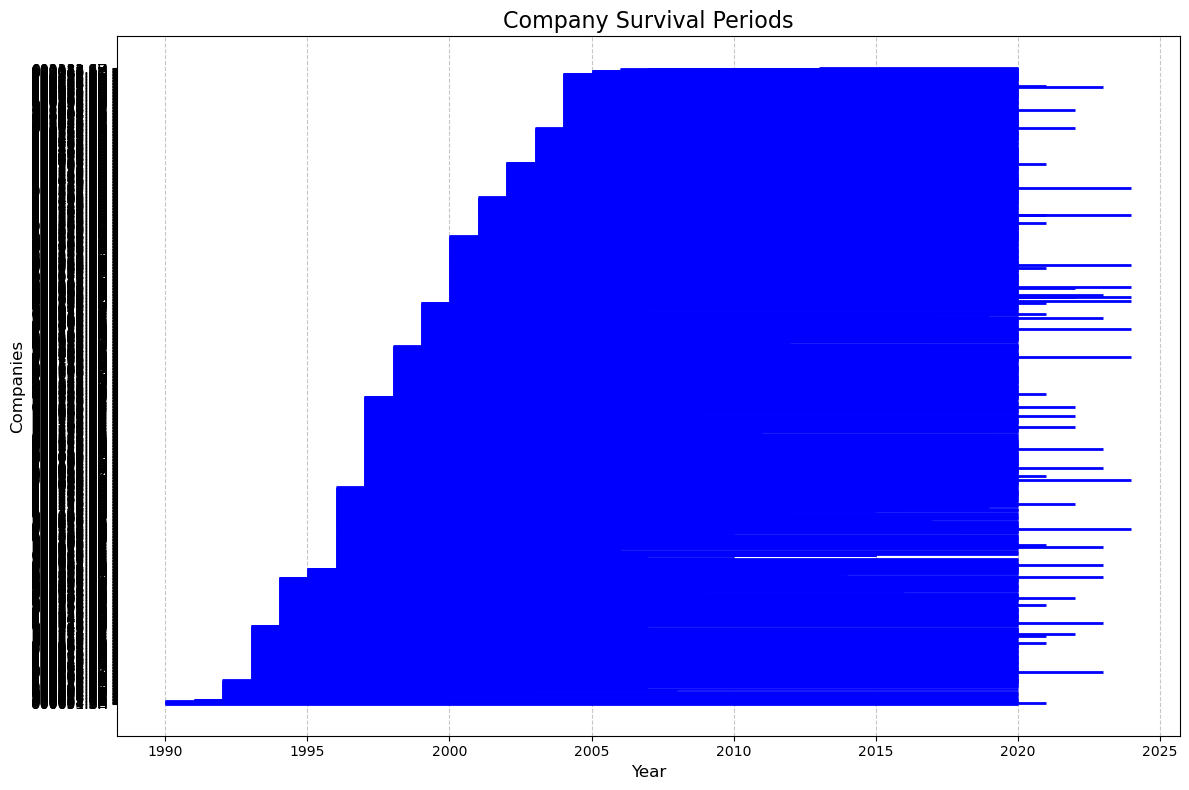

In [14]:
import matplotlib.pyplot as plt
df = best_dataset.copy()
# Ensure the start and end dates are in datetime format
df["start_year"] = pd.to_datetime(df["listing_date"]).dt.year
df["end_year"] = pd.to_datetime(df["bankrupcty_date"]).dt.year  # Replace NaN with 2023 for censoring

# Sort the dataset by start year for better visualization
df = df.sort_values("start_year").reset_index(drop=True)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot a horizontal line for each company
for i, row in df.iterrows():
    plt.hlines(
        y=i,  # Use the index as the y-coordinate
        xmin=row["start_year"],  # Start year
        xmax=row["end_year"],  # End year
        color="blue",
        linewidth=2,
    )

# Add labels and grid
plt.title("Company Survival Periods", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Companies", fontsize=12)
plt.yticks(range(len(df)), df["Securities.code"])  # Use company IDs as labels
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

### Conclusion:
We are picking the years 2010 - 2015, i.e., 6 years.<br>
Dropping off the lags of features left, which are not from years 2010-2015.

In [15]:
new_copy_df =best_dataset.copy()
new_columns_info_copy = new_columns_info.copy()
new_columns_info_copy["Year"] =new_columns_info_copy["Year"].astype(int)
for _, row in new_columns_info_copy.iterrows():
    if not (2010 < row["Year"] < 2015):
        new_copy_df = new_copy_df.drop(columns=row["Column Names"])


In [16]:
print(new_columns_info_copy["Feature"].nunique())
print(new_copy_df.shape)

35
(1058, 556)


## Imputing Data

In [17]:
# imputing  the data
import numpy as np
from py_soft_impute.soft_impute import SoftImpute
def soft_impute(df, columns):
    df_to_impute = df[columns]
    df_to_impute= df_to_impute.replace([np.inf, -np.inf], np.nan)
    df_to_impute = df_to_impute.fillna(0)
    clf = SoftImpute(J=2, lambda_=0.0)
    fit = clf.fit(df_to_impute.values)
    imputed_array = clf.predict(df_to_impute.values)
    df_new=pd.DataFrame(imputed_array, columns=columns)
    df.iloc[:,6:-6] = df_new
    return df

In [18]:
columns = new_copy_df.iloc[:, 6:-6].columns
imputed_df = soft_impute(new_copy_df, columns)

In [19]:
# Basic information about the dataset
imputed_df.describe()

,Current.assets.turnover.ratio.[Reporting.Period].2011.First.Quarter.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].2011.Interim.Report.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].Third.Quarter.of.2011.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].2011.Annual.Report.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].2012.First.Quarter.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].2012.Interim.Report.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].Third.Quarter.of.2012.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].2012.Annual.Report.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].2013.First.Quarter.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].2013.Interim.Report.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].Third.Quarter.of.2013.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].2013.Annual.Report.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].2014.First.Quarter.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].2014.Interim.Report.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].Third.Quarter.of.2014.[unit].times,Current.assets.turnover.ratio.[Reporting.Period].2014.Annual.Report.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2011.First.Quarter.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2011.Interim.Report.[unit].times,total.assets.turnover.ratio.[Reporting.Period].Third.Quarter.of.2011.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2011.Annual.Report.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2012.First.Quarter.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2012.Interim.Report.[unit].times,total.assets.turnover.ratio.[Reporting.Period].Third.Quarter.of.2012.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2012.Annual.Report.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2013.First.Quarter.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2013.Interim.Report.[unit].times,total.assets.turnover.ratio.[Reporting.Period].Third.Quarter.of.2013.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2013.Annual.Report.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2014.First.Quarter.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2014.Interim.Report.[unit].times,total.assets.turnover.ratio.[Reporting.Period].Third.Quarter.of.2014.[unit].times,total.assets.turnover.ratio.[Reporting.Period].2014.Annual.Report.[unit].times,current.ratio.[Reporting.Period].2011.First.Quarter,current.ratio.[Reporting.Period].2011.Interim.Report,current.ratio.[Reporting.Period].Third.Quarter.of.2011,current.ratio.[Reporting.Period].2011.Annual.Report,current.ratio.[Reporting.Period].2012.First.Quarter,current.ratio.[Reporting.Period].2012.Interim.Report,current.ratio.[Reporting.Period].Third.Quarter.of.2012,current.ratio.[Reporting.Period].2012.Annual.Report,current.ratio.[Reporting.Period].2013.First.Quarter,current.ratio.[Reporting.Period].2013.Interim.Report,current.ratio.[Reporting.Period].Third.Quarter.of.2013,current.ratio.[Reporting.Period].2013.Annual.Report,current.ratio.[Reporting.Period].2014.First.Quarter,current.ratio.[Reporting.Period].2014.Interim.Report,current.ratio.[Reporting.Period].Third.Quarter.of.2014,current.ratio.[Reporting.Period].2014.Annual.Report,quick.ratio.[Reporting.Period].2011.First.Quarter,quick.ratio.[Reporting.Period].2011.Interim.Report,quick.ratio.[Reporting.Period].Third.Quarter.of.2011,quick.ratio.[Reporting.Period].2011.Annual.Report,quick.ratio.[Reporting.Period].2012.First.Quarter,quick.ratio.[Reporting.Period].2012.Interim.Report,quick.ratio.[Reporting.Period].Third.Quarter.of.2012,quick.ratio.[Reporting.Period].2012.Annual.Report,quick.ratio.[Reporting.Period].2013.First.Quarter,quick.ratio.[Reporting.Period].2013.Interim.Report,quick.ratio.[Reporting.Period].Third.Quarter.of.20

In [20]:
imputed_df["status"].value_counts()

status
0    680
1    378
Name: count, dtype: int64

## Kaplan Meier Curve

In [21]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
def kaplan_Meier_model(df,s):

    # Fit the Kaplan-Meier model
    kmf = KaplanMeierFitter()
    kmf.fit(df['survival_time'], event_observed=df['status'])
    # Plot the survival curve
    kmf.plot_survival_function()
    plt.title(f"Kaplan-Meier Survival Curve with s = {s}")
    plt.xlabel('Time (Years)')
    plt.ylabel('Survival Probability')
    plt.show()


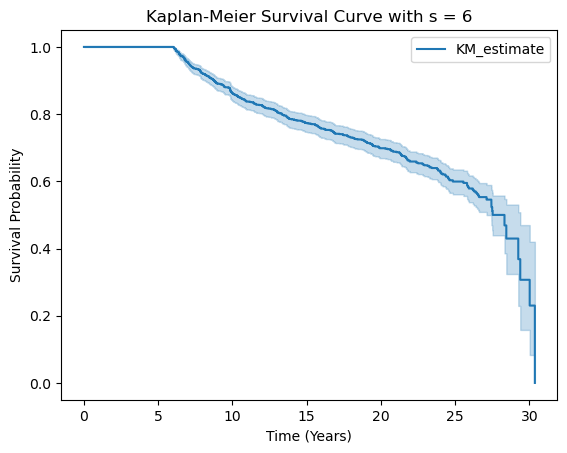

In [22]:
kaplan_Meier_model(imputed_df,6)

## Same steps with s=10


In [23]:
new_columns_info_10  = get_features_info(best_dataset1)
new_columns_info_10 = new_columns_info_10[6:-6].reset_index(drop=True)

In [24]:
new_copy_df_10 =best_dataset1.copy()
new_columns_info_10["Year"] =new_columns_info_10["Year"].astype(int)
for _, row in new_columns_info_10.iterrows():
    if not (2010 < row["Year"] < 2015):
        new_copy_df_10 = new_copy_df_10.drop(columns=row["Column Names"])

print(new_columns_info_10["Feature"].nunique())
print(new_copy_df_10.shape)

34
(911, 540)


### Imputing data

In [25]:
columns = new_copy_df_10.iloc[:, 6:-6].columns
imputed_df_10 = soft_impute(new_copy_df_10, columns)
imputed_df_10["status"].value_counts()

status
0    679
1    232
Name: count, dtype: int64

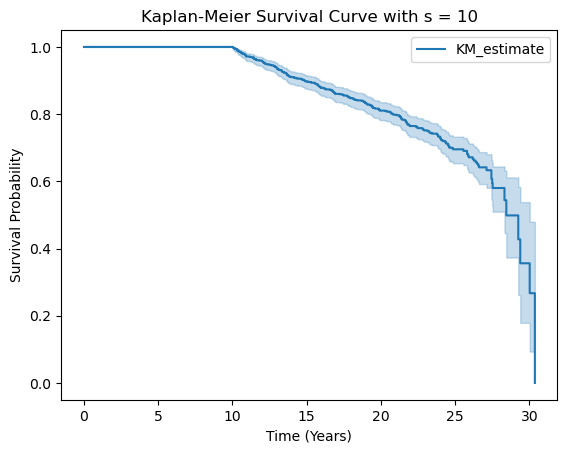

In [26]:
kaplan_Meier_model(imputed_df_10,10)

In [27]:
imputed_df_10.to_csv("/Users/nk/Acedemic/Masters/KULEUVEN/Thesis/project_second/survival_project/imputed_data_10.csv", index=False)
imputed_df.to_csv("/Users/nk/Acedemic/Masters/KULEUVEN/Thesis/project_second/survival_project/imputed_data_6.csv", index=False)